In [57]:
%matplotlib notebook

In [58]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from skimage.feature import canny
from skimage.draw import circle
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')
              
def display_labels_on_image(image,label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image,cmap=plt.cm.gray)
    edges = np.nonzero(canny(label_image.astype(np.float)))
    ax.plot(edges[1],edges[0],'.b',markersize=3)
    ax.axis('image')
    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

In [59]:
d = parse_dicom_tree('/home/hansenms/data/PANDA/NIH_PANDA/DAY8_NIST/DICOM')
print_dicom_summary(d)

6	1	IR_MiniFLASH_pk_TI10__GT
7	1	IR_MiniFLASH_pk_TI10__GT_SNR_MAP
8	1	IR_MiniFLASH_pk_TI20__GT
9	1	IR_MiniFLASH_pk_TI20__GT_SNR_MAP
10	1	IR_MiniFLASH_pk_TI30__GT
11	1	IR_MiniFLASH_pk_TI30__GT_SNR_MAP
12	1	IR_MiniFLASH_pk_TI40__GT
13	1	IR_MiniFLASH_pk_TI40__GT_SNR_MAP
14	1	IR_MiniFLASH_pk_TI80__GT
15	1	IR_MiniFLASH_pk_TI80__GT_SNR_MAP
16	1	IR_MiniFLASH_pk_TI120__GT
17	1	IR_MiniFLASH_pk_TI120__GT_SNR_MAP
18	1	IR_MiniFLASH_pk_TI240__GT
19	1	IR_MiniFLASH_pk_TI240__GT_SNR_MAP
20	1	IR_MiniFLASH_pk_TI320__GT
21	1	IR_MiniFLASH_pk_TI320__GT_SNR_MAP
22	1	IR_MiniFLASH_pk_TI640__GT
23	1	IR_MiniFLASH_pk_TI640__GT_SNR_MAP
24	1	IR_MiniFLASH_pk_TI1300__GT
25	1	IR_MiniFLASH_pk_TI1300__GT_SNR_MAP
26	1	IR_MiniFLASH_pk_TI1300__GT
27	1	IR_MiniFLASH_pk_TI1300__GT_SNR_MAP
28	1	se_msh_TE20__GT
29	1	se_msh_TE20__GT_SNR_MAP
30	1	se_msh_TE40__GT
31	1	se_msh_TE40__GT_SNR_MAP
32	1	se_msh_TE80__GT
33	1	se_msh_TE80__GT_SNR_MAP
34	1	se_msh_TE160__GT
35	1	se_msh_TE160__GT_SNR_MAP
36	1	se_msh_TE320__GT
37	1	se_msh_TE32

In [91]:
fa_data = [27] #flip angle measurements
IR_data = [7,9,11,13,15,17,19,21,23,25,27] #Inversion Recovery (T1) data
SE_data = [29,31,33,35,37,29] #Spin Echo (T2) data
#T2star_data = [11] #T2* data
#SSFP_data = [59] #SSFP images (multiple reps)
#GRE_data = [16] #GRE images (multiple reps)

<IPython.core.display.Javascript object>


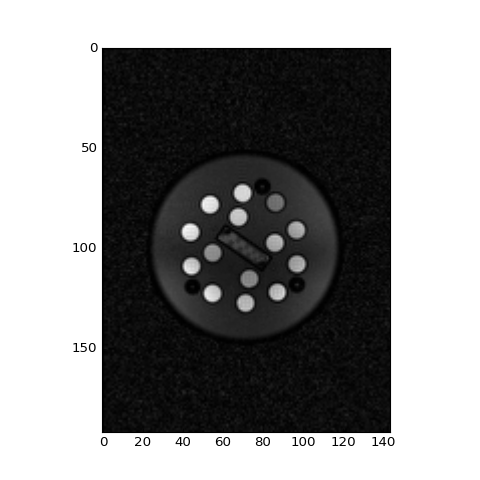

In [82]:
# Initial overview image
im = d[IR_data[-1]][0]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(im.pixel_array,cmap=plt.cm.gray)

In [63]:
coords = []

def onclick(event):
    coords.append((event.xdata, event.ydata))

    if event.button == 3:
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [64]:
coords

[(53.393482490272355, 78.522859922179009),
 (69.969357976653669, 72.919747081712103),
 (86.311770428015535, 77.355544747081751),
 (96.817607003891027, 91.129863813229605),
 (96.817607003891027, 108.40612840466929),
 (87.245622568093353, 121.94698443579769),
 (71.370136186770424, 128.01702334630352),
 (54.794260700389096, 122.88083657587551),
 (44.288424124513604, 109.33998054474711),
 (44.054961089494149, 92.063715953307423),
 (67.868190661478593, 84.592898832684853),
 (86.078307392996095, 97.900291828793797),
 (73.237840466926059, 115.64348249027239),
 (54.794260700389096, 102.5695525291829)]

In [65]:
t1_coords = [(53.393482490272355, 78.522859922179009),
 (69.969357976653669, 72.919747081712103),
 (86.311770428015535, 77.355544747081751),
 (96.817607003891027, 91.129863813229605),
 (96.817607003891027, 108.40612840466929),
 (87.245622568093353, 121.94698443579769),
 (71.370136186770424, 128.01702334630352),
 (54.794260700389096, 122.88083657587551),
 (44.288424124513604, 109.33998054474711),
 (44.054961089494149, 92.063715953307423),
 (67.868190661478593, 84.592898832684853),
 (86.078307392996095, 97.900291828793797),
 (73.237840466926059, 115.64348249027239),
 (54.794260700389096, 102.5695525291829)]

<IPython.core.display.Javascript object>


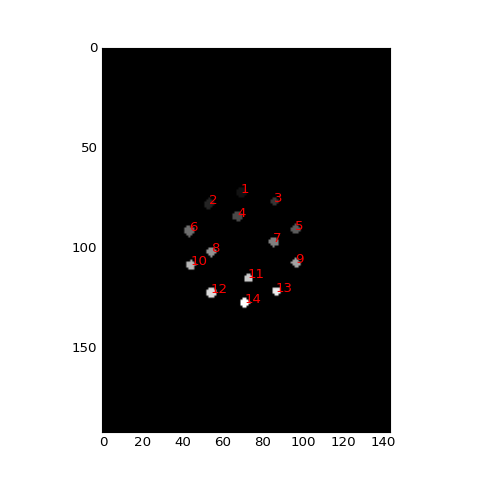

In [92]:
labels_automatic = label_image(d[IR_data[-1]][0].pixel_array, threshold_sensitivity=0.9,erosion_size=4)
display_labels(labels_automatic)

<IPython.core.display.Javascript object>


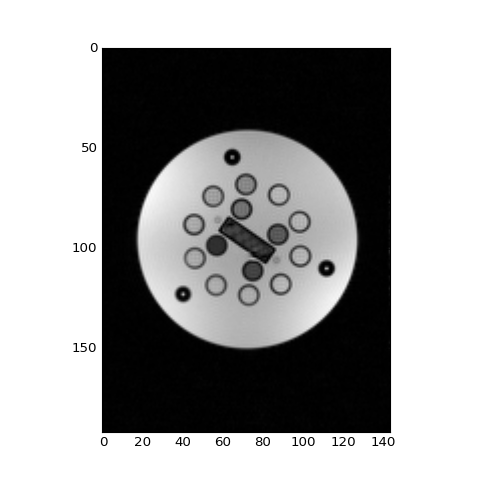

In [66]:
im = d[SE_data[0]][0]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(im.pixel_array,cmap=plt.cm.gray)

In [53]:
coords = []

def onclick(event):
    coords.append((event.xdata, event.ydata))

    if event.button == 3:
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [54]:
coords

[]

In [67]:
t2_coords = [(55.269067796610166, 73.794491525423723),
 (71.879237288135585, 68.031779661016969),
 (88.150423728813564, 73.455508474576277),
 (98.658898305084762, 86.675847457627128),
 (98.658898305084762, 103.96398305084746),
 (88.828389830508485, 117.86228813559322),
 (73.235169491525426, 123.625),
 (56.625000000000007, 118.8792372881356),
 (45.777542372881364, 104.64194915254238),
 (45.777542372881364, 88.370762711864415),
 (69.845338983050851, 80.5741525423729),
 (87.811440677966118, 93.455508474576277),
 (74.930084745762713, 111.08262711864407),
 (56.963983050847453, 98.540254237288138)]

In [68]:
radius=1
t1_labels = np.zeros(im.pixel_array.shape,dtype=np.int)
for idx,c in enumerate(t1_coords):
    cc,rr = circle(c[1],c[0],radius)
    t1_labels[cc,rr] = idx+1
    
t2_labels = np.zeros(im.pixel_array.shape,dtype=np.int)
for idx,c in enumerate(t2_coords):
    cc,rr = circle(c[1],c[0],radius)
    t2_labels[cc,rr] = idx+1

<IPython.core.display.Javascript object>


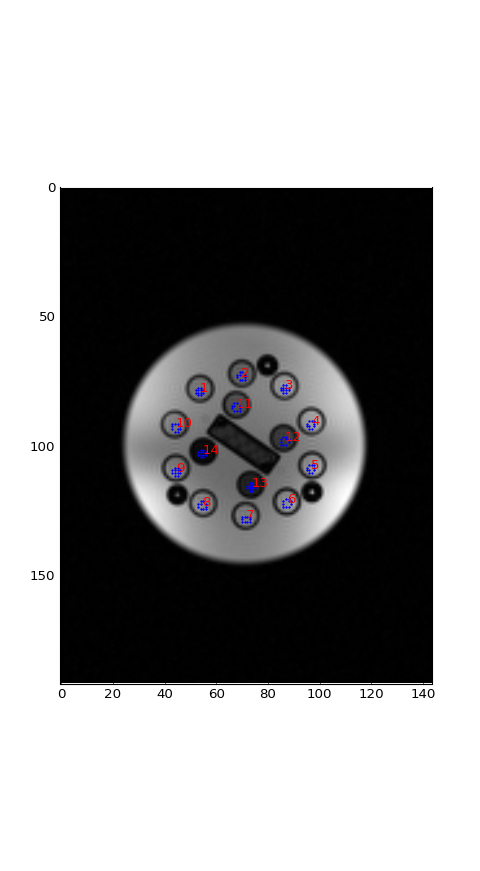

In [69]:
display_labels_on_image(d[IR_data[0]][0].pixel_array,t1_labels)

<IPython.core.display.Javascript object>


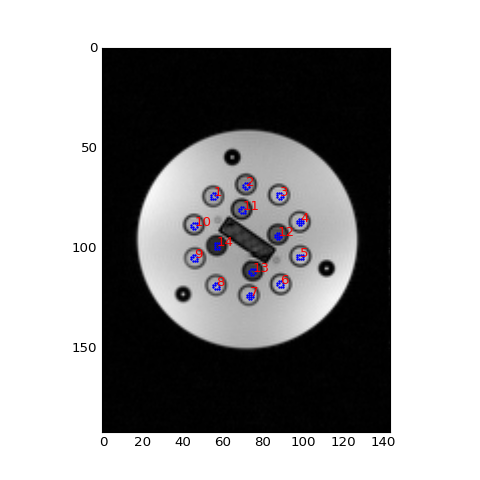

In [43]:
display_labels_on_image(d[SE_data[0]][0].pixel_array,t2_labels)

In [44]:
t1_tubes = range(1,15)
t2_tubes = range(1,15)

<IPython.core.display.Javascript object>


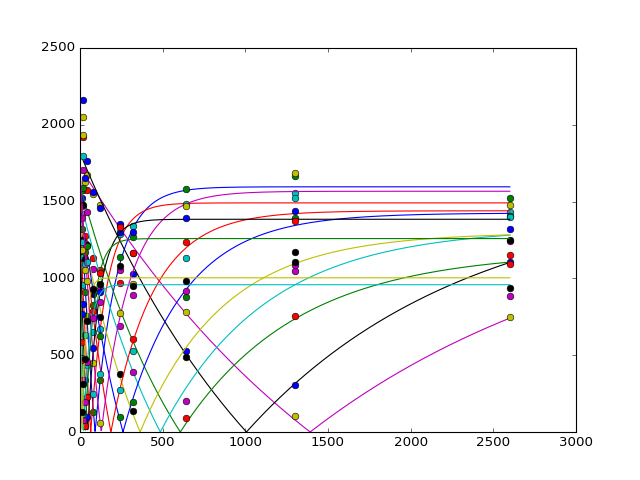

In [96]:
# Estimate T1
tubes = t1_tubes
labels = t1_labels
dcms = [d[i][0] for i in IR_data]

TIs, IRSignal = get_IR_data(dcms, labels, tubes)
fits_t1 = fit_t1_mag_IR(TIs,IRSignal)

fig, ax = plt.subplots(ncols=1, nrows=1)
line_vals = np.linspace(0,np.max(TIs),1000)
for t in range(0,len(tubes)):
    _ = ax.plot(line_vals,np.abs(fits_t1[t][0]-fits_t1[t][1]*np.exp(-line_vals/fits_t1[t][2])),'-')
    _ = ax.plot(TIs,IRSignal[:,t],'o')


In [87]:
# Print T1 values
[x[2] for x in fits_t1]

[99.034917511242725,
 132.09966925586093,
 1855.1522877442571,
 70.680251090445068,
 1313.16599749989,
 178.74721410775231,
 51.131072405130695,
 24.357337023401929,
 696.11409567962653,
 255.4724978255887,
 36.589093291591482,
 370.16015897384591,
 643.53739213113749,
 497.8211187171525]

<IPython.core.display.Javascript object>


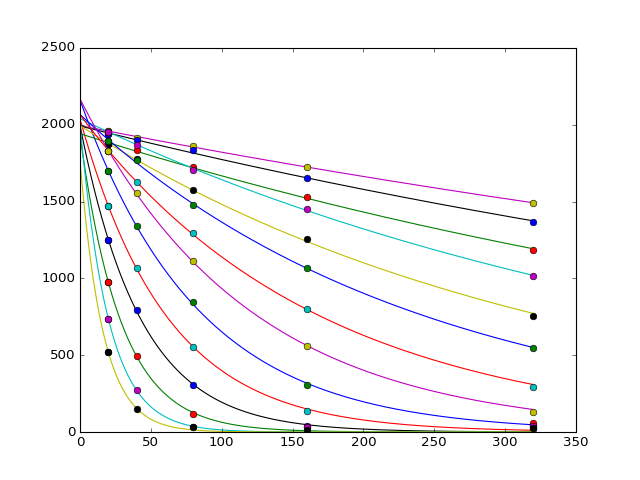

In [48]:
# Estimate T2
tubes = t2_tubes
labels = t2_labels
TEs, SESignal = get_SE_data([d[i][0] for i in SE_data],labels,tubes)
fits_t2 = fit_t2_SE(TEs,SESignal)

fig, ax = plt.subplots(ncols=1, nrows=1)
line_vals = np.linspace(0,np.max(TEs),1000)
for t in range(0,len(tubes)):
    _ = ax.plot(line_vals,fits_t2[t][0]*np.exp(-line_vals/fits_t2[t][1]),'-')
    _ = ax.plot(TEs,SESignal[:,t],'o')

In [49]:
# Print T2 values
[x[1] for x in fits_t2]

[83.436252696900169,
 61.345699863563411,
 1102.3075256838938,
 861.82203876326514,
 656.10854466031935,
 461.04067286365324,
 336.98996503816034,
 241.56832508162,
 168.31547616627938,
 118.68893289150674,
 42.880200599348527,
 29.256997155323532,
 19.976016335312568,
 16.374221338986327]

In [50]:
from pandas import DataFrame

def display_labels_on_image(image,label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

In [52]:
d = {'Sample': range(1,15), 'T1': [x[2] for x in fits_t1], 'T2': [x[1] for x in fits_t2]}
df = DataFrame(data=d)

In [63]:
df[['Sample','T1','T2']]

,Sample,T1,T2
0,1,453.168924,43.007852
1,2,1126.611125,45.587424
2,3,497.558803,198.392028
3,4,589.957358,43.974645
4,5,1355.553475,48.805418
5,6,1594.402852,237.587407
6,7,318.612890,44.448350
7,8,823.136370,47.509301
8,9,273.088726,169.590134
9,10,580.036218,51.997906
